# Исследование влияния защищенного протокола HTTPS на позицию сайта в Яндексе
       

In [1]:
# Рисовать графики сразу же
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок

Возьмем для анализа данные выдачи для 171-го запроса по тематике "seo продвижение"

In [2]:
# путь к папке в которой находятся архивы seranking
path='data/2018-08-15/88/'

In [28]:
# Распакуем архивы

import gzip
import os
from tqdm import tnrange, tqdm_notebook, tqdm

# путь к папке в которой находятся архивы seranking
path='data/2018-08-15/61/'

# Распаковка всех архивных файлов *.gz из папки 'path'
for i in tnrange(len(os.listdir(path))):
    files=os.listdir(path)[i]
    if files[-4:].find('.gz')>-1:
        with gzip.open(path+files, 'rb') as in_file:
            s = in_file.read()
            # Now store the uncompressed data
            path_to_store = files[:-3]  # remove the '.gz' from the filename
            # store uncompressed file data from 's' variable
            with open(path+path_to_store, 'wb') as f:
                f.write(s)

A Jupyter Widget

In [40]:
# Преобразуем файл seranking.html обратно к формату xml yandex

#path='data/2018-08-15/61/'

def dumpseranktoxml(dump):
    """функция для преобразования dump файла выдачи созданных seranking в xmlyandex"""
    if dump[-4:].find('html')>-1:
        i = open(dump, encoding="utf8") # чтение файла
        lines=i.readlines()  # получаем список состоящие из строк файла
        lines[0]=lines[0][-39:] # удаляем лишний код из первой строки
        newname=dump[:-4]+'xml'  # новое имя файла с новым расширением xml
        i.close()
        # создание файла xml 
        o = open(newname, 'w', encoding="utf8")
        o.writelines(lines)
        o.close()
    return

for i in tnrange(3400, len(os.listdir(path))):
    files=os.listdir(path)[i]
    dumpseranktoxml(path+files)

A Jupyter Widget

Импортируем данные из всех xml файлов выдачи в таублицу dataframe

In [41]:
%%time
import os
import xml.etree.cElementTree as et # импортируем модуль для работы с xml
import pandas as pd # импортируем модуль для анализа данных и создания таблиц
from tqdm import tnrange, tqdm_notebook, tqdm

def xmltodataframe(file, dataframe):
    """
    функция преобразования xmlyandex в dataframe таблицу
    file -  путь к файлу xmlyandex, 
    dataframe - желательно пустой 
    """
    parsedXML = et.parse(file) # парсим файл xml
    root=parsedXML.getroot() # для работы с данными нам нужен объект не дерево, а корневой узел.
    sitesonpage=int(root[1][5][0][7].attrib['last'])-int(root[1][5][0][7].attrib['first'])+1
    dataframe[root[0][0].tag]=[root[0][0].text]*sitesonpage # создаем первую колонку с запросом 100=last="300" - first="201"
    dataframe['pos']=dataframe.index+int(root[1][5][0][7].attrib['first']) # добавляем колонку позиция = range(first, last)

    def addcolumn(root, tag, dataframe): 
        """функцию, которая добавляет столбец в таблицу"""
        series = pd.Series() # таблица
        for i in root.iter(tag):
            series = series.append(pd.Series([i.text]), ignore_index=True)   
        dataframe[tag]=series
        return

    # создаем список тегов, данные которых нужно добавить в таблицу
    tag= ['url', 'doccount', 'size', 'domain', 'charset', 'mime-type'] 
    for i in tag: #добавлям столбцы в таблицу
        addcolumn(root, i, dataframe)
    return

path='data/2018-08-15/61/'

files=os.listdir(path)
xmlfiles=[]

for i in tnrange(len(files), desc='список xml'):
    if files[i].find('xml')>=0:
        if files[i].find('error')<0:
            xmlfiles.append(files[i])
        
df = pd.DataFrame()

for i in tnrange(len(xmlfiles), desc='xml в dataframe'):
    d =path+xmlfiles[i]
    df_temp = pd.DataFrame()
    xmltodataframe(d,df_temp)
    df=df.append(df_temp, ignore_index=True)

#df.dropna(how='any')
df['doccount'] = df['doccount'].astype('float')
df['size'] = df['size'].astype('float')
df.info()
    

A Jupyter Widget

A Jupyter Widget


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93430 entries, 0 to 93429
Data columns (total 8 columns):
query        93430 non-null object
pos          93430 non-null int64
url          93428 non-null object
doccount     93428 non-null float64
size         93428 non-null float64
domain       93428 non-null object
charset      93428 non-null object
mime-type    93428 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 5.7+ MB
Wall time: 8min 12s


Мы получили данные выдачи, всего 93428 позиций и релевантных страниц

Извлечем признак номер страницы при выдаче по 10 сайтов на страницу.

In [42]:
def pageof10(pos):
    return int('0'+str(pos-1)[:-1])+1
df['page']=df.pos.apply(pageof10)
df.head()

,query,pos,url,doccount,size,domain,charset,mime-type,page
0,seo оптимизация сайта заказать,1,https://kwork.ru/categories/optimization,6129.0,2976.0,kwork.ru,utf-8,text/html,1
1,seo оптимизация сайта заказать,2,https://divly.ru/seo,4.0,1795.0,divly.ru,utf-8,text/html,1
2,seo оптимизация сайта заказать,3,https://optimizator.su/optimization/,34.0,2248.0,optimizator.su,utf-8,text/html,1
3,seo оптимизация сайта заказать,4,http://freelance.youdo.com/marketing/seo/optim...,168.0,2849.0,freelance.youdo.com,utf-8,text/html,1
4,seo оптимизация сайта заказать,5,https://seoXL.ru/seo_optimizacija_sajta/,18.0,1321.0,seoXL.ru,utf-8,text/html,1


Извлечем признак наличия у сайта безопасного соединения https

In [43]:
df['https']=df.url.str.find('https')>-1
df.head()

,query,pos,url,doccount,size,domain,charset,mime-type,page,https
0,seo оптимизация сайта заказать,1,https://kwork.ru/categories/optimization,6129.0,2976.0,kwork.ru,utf-8,text/html,1,True
1,seo оптимизация сайта заказать,2,https://divly.ru/seo,4.0,1795.0,divly.ru,utf-8,text/html,1,True
2,seo оптимизация сайта заказать,3,https://optimizator.su/optimization/,34.0,2248.0,optimizator.su,utf-8,text/html,1,True
3,seo оптимизация сайта заказать,4,http://freelance.youdo.com/marketing/seo/optim...,168.0,2849.0,freelance.youdo.com,utf-8,text/html,1,False
4,seo оптимизация сайта заказать,5,https://seoXL.ru/seo_optimizacija_sajta/,18.0,1321.0,seoXL.ru,utf-8,text/html,1,True


In [2]:
#df=pd.read_pickle('https.pkl')
#, lineterminator='\n')
df.head()

,query,pos,url,doccount,size,domain,charset,mime-type,page,https
0,seo оптимизация сайта заказать,1,https://kwork.ru/categories/optimization,6129.0,2976.0,kwork.ru,utf-8,text/html,1,True
1,seo оптимизация сайта заказать,2,https://divly.ru/seo,4.0,1795.0,divly.ru,utf-8,text/html,1,True
2,seo оптимизация сайта заказать,3,https://optimizator.su/optimization/,34.0,2248.0,optimizator.su,utf-8,text/html,1,True
3,seo оптимизация сайта заказать,4,http://freelance.youdo.com/marketing/seo/optim...,168.0,2849.0,freelance.youdo.com,utf-8,text/html,1,False
4,seo оптимизация сайта заказать,5,https://seoXL.ru/seo_optimizacija_sajta/,18.0,1321.0,seoXL.ru,utf-8,text/html,1,True


Посмотри на долю https сайтов в ТОП 10 Яндекса

In [44]:
df[df.pos<11]['https'].value_counts()

True     1289
False     421
Name: https, dtype: int64

В нашей выборке 1289 сайтов используют безопасное https соединение, и 421 используют обычное http.

Сравним с распределение признака у сайтов вне ТОП 10 Яндекса

In [45]:
df[df.pos>10]['https'].value_counts()

False    47714
True     44006
Name: https, dtype: int64

Делится примерно по ровно 47714 - http, и сайтов 44006 - https

Посмотрем на распределение типа соединения по страницам. Примечание: На одной странице поисковой выдаче по 10 сайтов. 

In [46]:
pd.crosstab(df['https'], df['page'], margins=True)

page,1,2,3,4,5,6,7,8,9,10,...,92,93,94,95,96,97,98,99,100,All
https,,,,,,,,,,,,,,,,,,,,,
False,421,514,559,681,726,775,845,903,1020,1072,...,265,244,247,264,253,269,248,249,228,48135
True,1289,1196,1151,1029,984,935,865,807,690,637,...,255,276,273,256,267,251,272,271,258,45295
All,1710,1710,1710,1710,1710,1710,1710,1710,1710,1709,...,520,520,520,520,520,520,520,520,486,93430


Отобразим тоже самое на графиках

Общее распределение типа соединения

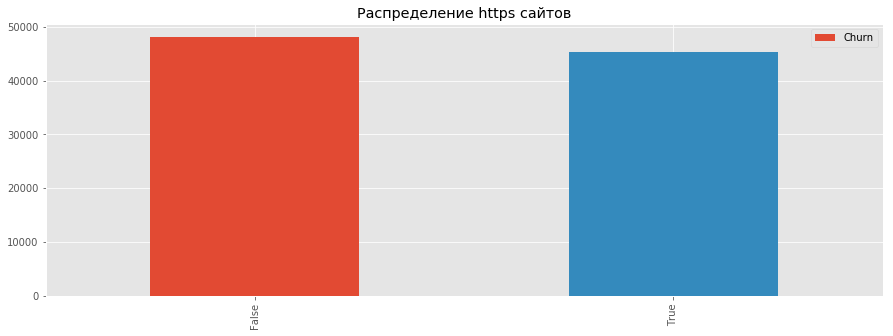

In [48]:
df['https'].value_counts().plot(kind='bar', label='https')
plt.legend()
plt.title('Распределение https сайтов');

Распределение типа соединения по страницам поисковой выдачи

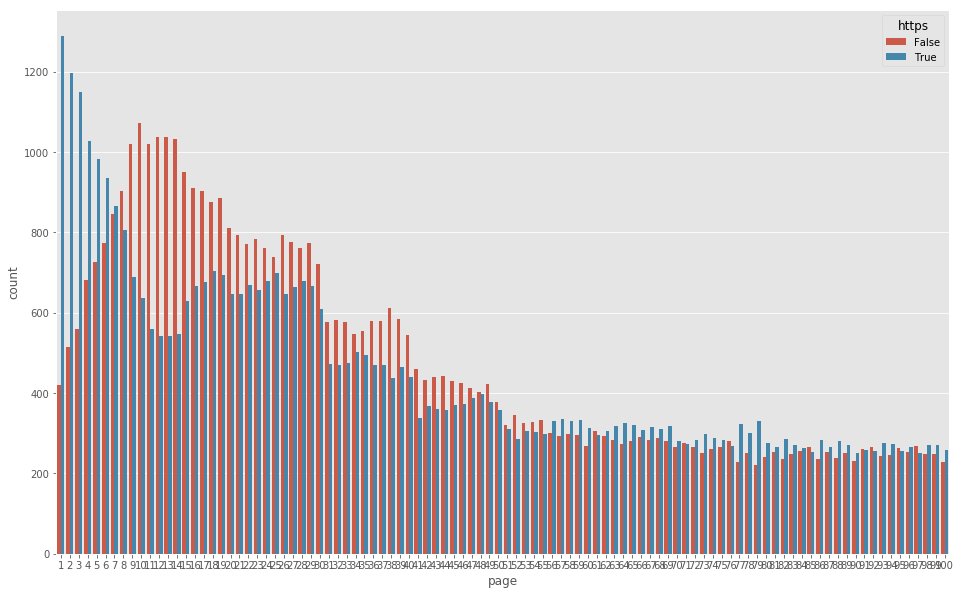

In [4]:
# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 16, 10

sns.countplot(x='page', hue='https', data=df);

Отобразим первую половичну до 50 страницы поисковой системы

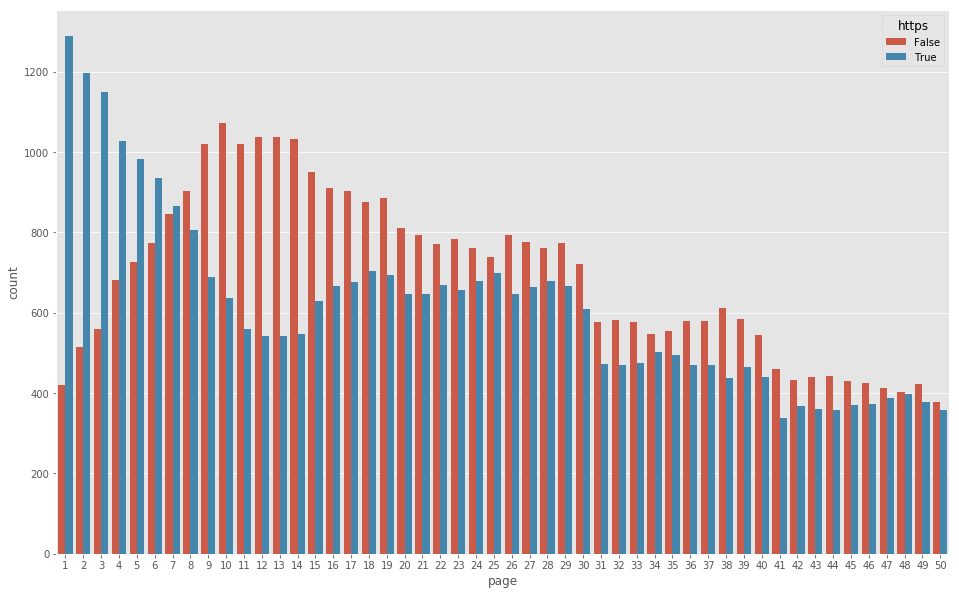

In [5]:
df2=df[df['page']<51]
sns.countplot(x='page', hue='https', data=df2);

In [38]:
#сохраним данные
df.to_csv('https.csv')

На первой странице (топ10) Яндекса количество сайтов использующих безопасное соединение в 3 раза больше. 

Рассчитаем процент hhtps соединения на страницах поисковых систем

In [17]:
d = {False : 0, True : 1}
df['https'] = df['https'].map(d)
df.head()

,query,pos,url,doccount,size,domain,charset,mime-type,page,https
0,seo оптимизация сайта заказать,1,https://kwork.ru/categories/optimization,6129.0,2976.0,kwork.ru,utf-8,text/html,1,1
1,seo оптимизация сайта заказать,2,https://divly.ru/seo,4.0,1795.0,divly.ru,utf-8,text/html,1,1
2,seo оптимизация сайта заказать,3,https://optimizator.su/optimization/,34.0,2248.0,optimizator.su,utf-8,text/html,1,1
3,seo оптимизация сайта заказать,4,http://freelance.youdo.com/marketing/seo/optim...,168.0,2849.0,freelance.youdo.com,utf-8,text/html,1,0
4,seo оптимизация сайта заказать,5,https://seoXL.ru/seo_optimizacija_sajta/,18.0,1321.0,seoXL.ru,utf-8,text/html,1,1


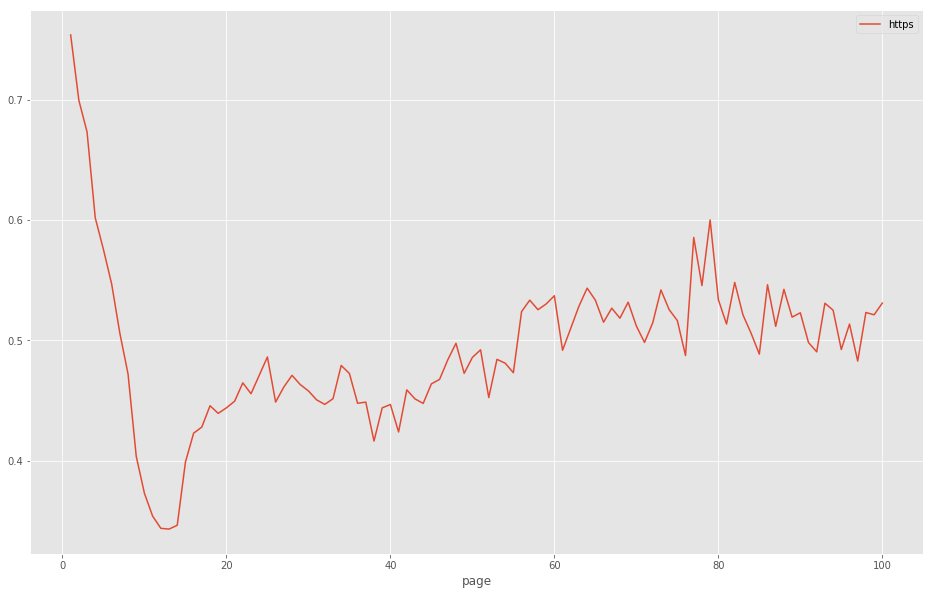

In [29]:
df.pivot_table('https', index='page').plot();

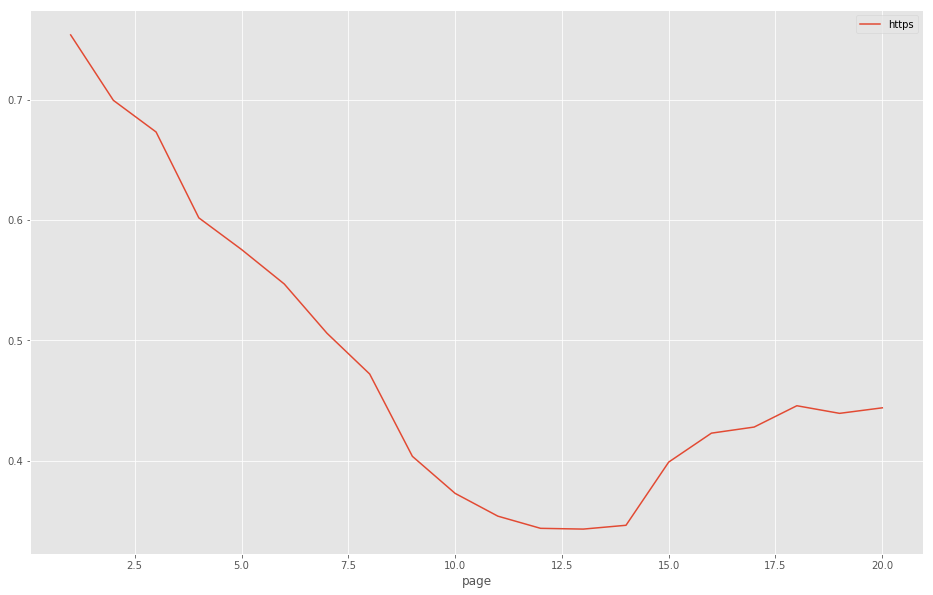

In [36]:
df[df['page']<21].pivot_table('https', index='page').plot();

# Вывод: 
Использование https положительно влият по позиции сайта, если сайт находится в Яндексе на позиции с 1 по 12 страницу (не дальше 100 позиции)
